# Psyche Explorer (Model Training)

This notebook uses an openly available <a href="https://www.kaggle.com/datasets/pavlorymarchuk/test3434">dataset</a> on Kaggle to train a machine learning model to predict what type of personality someone has, based on the answers they provide to a series of questions, each of them corresponding to a particular trait of the <b>Big Five Personality Test</b>:

1. Openness
2. Conscientiousness
3. Extraversion
4. Agreeableness
5. Neuroticism

The trained model will then be deployed to a live environment (Azure Machine Learning, Amazon Sagemaker, Heroku Cloud etc.), which will be accessible to a web-based frontend which is also deployed in the same environment. Users can then answer the series of questions through the frontend, which will compute numerical values ("scores") for the above traits and send them to the model (with some additional data such as age and gender). The model in turn will predict the target personality type of the user and return that to the frontend to be displayed to the user.

---

## Initialization

In [1]:
# General imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Creating a Pandas dataframe using the training data

df_train = pd.read_csv('./data/train.csv')

df_train

,Gender,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality (Class label)
0,Male,17,7,4,7,3,2,extraverted
1,Male,19,4,5,4,6,6,serious
2,Female,18,7,6,4,5,5,dependable
3,Female,22,5,6,7,4,3,extraverted
4,Female,19,7,4,6,5,4,lively
...,...,...,...,...,...,...,...,...
704,Female,20,4,5,6,6,1,responsible
705,Male,18,6,3,1,5,5,dependable
706,Male,22,5,2,3,6,1,serious
707,Male,19,5,6,5,7,5,extraverted


## Exploratory Data Analysis

In [3]:
# Checking whether the dataset has any missing values

missing_values = df_train.isnull().sum()

missing_values = missing_values.apply(lambda x: f'{x} missing values' if x > 0 else 'No missing values')

print(missing_values)

Gender                       No missing values
Age                          No missing values
openness                     No missing values
neuroticism                  No missing values
conscientiousness            No missing values
agreeableness                No missing values
extraversion                 No missing values
Personality (Class label)    No missing values
dtype: object


In [4]:
# Checking how many unique targets are in the dataframe

targets = df_train.iloc[:, -1]
unique_targets = np.unique(targets)
print(unique_targets)
print(f'There are {len(unique_targets)} unique labels in the dataset.')

['dependable' 'extraverted' 'lively' 'responsible' 'serious']
There are 5 unique labels in the dataset.


In [5]:
# Checking the unique genders in the dataset

genders = df_train.iloc[:, 0]
unique_genders = np.unique(genders)
print(unique_genders)

['5' 'Female' 'Male']


There is a sample in the dataset with a `gender` value of 5! We will have to remove this obvious outlier from the dataset. Even though this is just one sample, our dataset itself is also relatively small, so when we encode the values of `gender` to 0 and 1 for 'male' and 'female', we come across two problems:

1. Since the dataset is small, and the value of the outlying is 5, it can interfere with the encoded values of the other samples' genders during training.
2. We cannot use label encoding like we usually do, as we have more than 2 possible values for `gender`.

In [6]:
# Checking the range of values in 'age'

ages = df_train.iloc[:, 1]
unique_ages = np.unique(ages)
print(f'Age ranges from {unique_ages[0]} to {unique_ages[-1]}')

Age ranges from 5 to 28


Including ages as low as 5 might be problematic for the model during training, as it will learn bad patterns from such outliers.

We will plot the distribution of `age` to see what such outliers we may have to deal with.

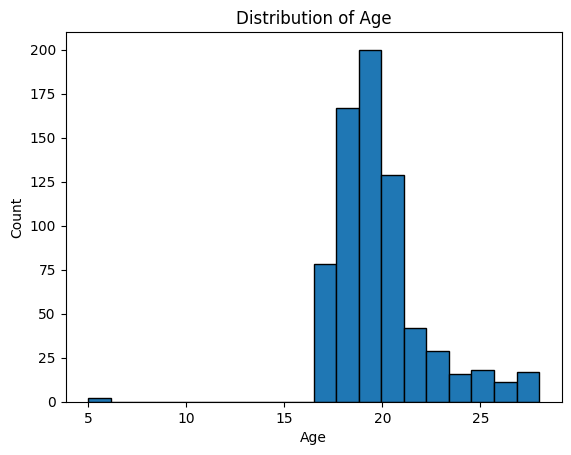

In [7]:
# Plotting the distribution of 'age' to check for outliers

plt.hist(ages, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

In [8]:
# Checking how many times 5 (an outlier) appears in 'age'

count = 0

for age in ages:
    if age == 5:
        count = count + 1
        
print(f"5 appears {count} times in 'age'")

5 appears 2 times in 'age'


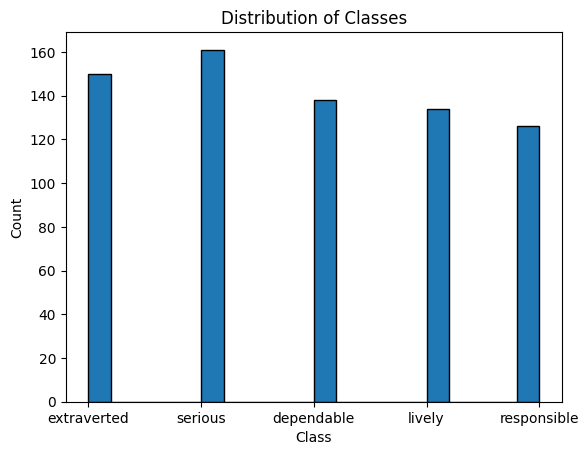

In [9]:
# Inspecting dataset for class inbalances

classes = df_train.iloc[:, -1]

plt.hist(classes, bins=20, edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

There doesn't seem to be a heavy class imbalance in the dataset, as evident in the above visualization.

## Data Preprocessing (Training Data)

In [10]:
# Fixing the names of the columns of the dataframe

df_train.rename(columns={'Personality (Class label)': 'personality'}, inplace=True)
df_train.rename(columns={'Gender': 'gender'}, inplace=True)
df_train.rename(columns={'Age': 'age'}, inplace=True)

# NOTE:
# inplace=True ensures that the dataframe 'df' is modified in place
# without creating a new dataframe. If this is omitted, a new dataframe
# is returned, which must be reassigned to a new variable.

df_train

,gender,age,openness,neuroticism,conscientiousness,agreeableness,extraversion,personality
0,Male,17,7,4,7,3,2,extraverted
1,Male,19,4,5,4,6,6,serious
2,Female,18,7,6,4,5,5,dependable
3,Female,22,5,6,7,4,3,extraverted
4,Female,19,7,4,6,5,4,lively
...,...,...,...,...,...,...,...,...
704,Female,20,4,5,6,6,1,responsible
705,Male,18,6,3,1,5,5,dependable
706,Male,22,5,2,3,6,1,serious
707,Male,19,5,6,5,7,5,extraverted


In [11]:
# Getting a list of the rows that have '5' as their gender

outlier_gender_rows = df_train.loc[df_train['gender'] == '5'].index.tolist()
print(outlier_gender_rows)

[449]


In [12]:
# Removing the outlying gender sample

df_train = df_train.drop(index=outlier_gender_rows)
df_train = df_train.reset_index(drop=True)

In [13]:
# Checking whether the outlier removal has occured properly

unique_genders = np.unique(df_train['gender'])
print(unique_genders)

['Female' 'Male']


In [14]:
# df.to_csv('clean_train.csv', index=False)

In [15]:
# Encoding the values of 'gender' using label encoding

from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()
df_train['gender'] = gender_encoder.fit_transform(df_train['gender'])

df_train

,gender,age,openness,neuroticism,conscientiousness,agreeableness,extraversion,personality
0,1,17,7,4,7,3,2,extraverted
1,1,19,4,5,4,6,6,serious
2,0,18,7,6,4,5,5,dependable
3,0,22,5,6,7,4,3,extraverted
4,0,19,7,4,6,5,4,lively
...,...,...,...,...,...,...,...,...
703,0,20,4,5,6,6,1,responsible
704,1,18,6,3,1,5,5,dependable
705,1,22,5,2,3,6,1,serious
706,1,19,5,6,5,7,5,extraverted


In [16]:
# Checking whether the gender encoding has occured properly

encoded_unique_genders = np.unique(df_train['gender'])
encoded_unique_genders

array([0, 1])

In [17]:
# Encoding the values of 'personality' (targets) using label encoding

target_encoder = LabelEncoder()
df_train['personality'] = target_encoder.fit_transform(df_train['personality'])

df_train

,gender,age,openness,neuroticism,conscientiousness,agreeableness,extraversion,personality
0,1,17,7,4,7,3,2,1
1,1,19,4,5,4,6,6,4
2,0,18,7,6,4,5,5,0
3,0,22,5,6,7,4,3,1
4,0,19,7,4,6,5,4,2
...,...,...,...,...,...,...,...,...
703,0,20,4,5,6,6,1,3
704,1,18,6,3,1,5,5,0
705,1,22,5,2,3,6,1,4
706,1,19,5,6,5,7,5,1


In [18]:
# Checking whether target encoding has occured properly

unique_targets = np.unique(df_train['personality'])
unique_targets

array([0, 1, 2, 3, 4])

In [19]:
# Getting a list of the rows that have an age of 5

outlier_age_rows = df_train.loc[df_train['age'] == 5].index.tolist()
print(outlier_age_rows)

[441, 457]


In [20]:
# Removing the outlying age sample

df_train = df_train.drop(index=outlier_age_rows)
df_train = df_train.reset_index(drop=True)

In [21]:
# Confirming removal of outlying age samples

ages = df_train.iloc[:, 1]

count = 0

for age in ages:
    if age == 5:
        count = count + 1
        
print(f"5 appears {count} times in 'age'")

5 appears 0 times in 'age'


In [22]:
# # Inspecting the skewness of features

# from scipy.stats import boxcox

# skewness = df_train.skew()
# skewed_features = skewness[skewness > 1].index

# for feature in skewed_features:
#     df_train[feature], _ = boxcox(df_train[feature] + 1)
    
# skewness = df_train.skew()
# skewness

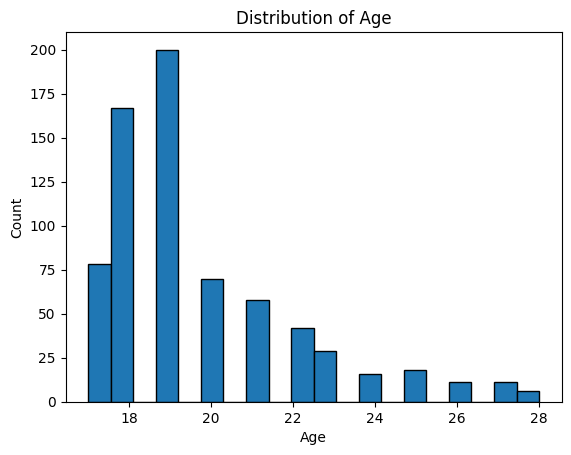

In [23]:
# Plotting the distribution of 'age' to inspect skewness

plt.hist(ages, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

## Preparing the Model

I have selected the `RandomForestClassifier` from <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">scikit-learn</a> due to the following reasons:

1. Random forests are usually used in multi-class classification.
1. Random forests are robust to outliers (in this case, the two samples having an age of 5).
2. Random forests perform well with small datasets.

<b>UPDATE</b>: so, apparently, `RandomForestClassifier` performed very poorly (less than 30% accuracy), and I had to manually try out other models.

In [24]:
# Imports related to the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [25]:
# Creating the model

# model = RandomForestClassifier(n_estimators=800,
#                                max_depth=10,
#                                min_samples_split=2,
#                                min_samples_leaf=1,
#                                max_features='log2',
#                                class_weight='balanced')

# model = KNeighborsClassifier(n_neighbors=7,
#                              weights='distance',
#                              algorithm='auto',
#                              leaf_size=30,
#                              p=2,
#                              metric='euclidean',
#                              metric_params=None,
#                              n_jobs=None)

# model = SVC(kernel='sigmoid', C=1.0)

# model = DecisionTreeClassifier()

model = LogisticRegression(max_iter=1000,
                           C=0.1,
                           solver='newton-cg',
                           penalty='l2')

model

LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg')

In [26]:
# # Data augmentation to increase the size of the dataset

# def augment_data(df, num_augmented_samples=5, noise_scale=0.1):
#     augmented_data = []
#     for _, row in df.iterrows():
#         for _ in range(num_augmented_samples):
#             augmented_sample = row + np.random.normal(scale=noise_scale, size=len(row))
#             augmented_data.append(augmented_sample)
#     augmented_df = pd.DataFrame(augmented_data, columns=df.columns)
#     return augmented_df

# df_train = augment_data(df_train, num_augmented_samples=5, noise_scale=0.1)

In [27]:
# Separating the features from the dataset

X_train = df_train[['gender', 'age', 'openness', 'neuroticism', 'conscientiousness', 'agreeableness', 'extraversion']]
X_train

,gender,age,openness,neuroticism,conscientiousness,agreeableness,extraversion
0,1,17,7,4,7,3,2
1,1,19,4,5,4,6,6
2,0,18,7,6,4,5,5
3,0,22,5,6,7,4,3
4,0,19,7,4,6,5,4
...,...,...,...,...,...,...,...
701,0,20,4,5,6,6,1
702,1,18,6,3,1,5,5
703,1,22,5,2,3,6,1
704,1,19,5,6,5,7,5


In [28]:
# # Scaling the feature vectors of the dataset

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler

# # NOTE:
# # model = LogisticRegression
# # model accuracy without normalization = 80.89%
# # model accuracy with MinMaxScaler = 66.88%
# # model accuracy with StandardScaler = 74.2%
# # model accuracy with RobustScaler = 54.14%

# # scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
# # scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # Convert the scaled array back to a dataFrame
# # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# print(X_train_scaled)

In [29]:
# Separating the targets from the dataset

y_train = df_train[['personality']]
y_train

,personality
0,1
1,4
2,0
3,1
4,2
...,...
701,3
702,0
703,4
704,1


In [30]:
# Converting y_train from a column vector to a 1-dimensional array

y_train = np.ravel(y_train)
y_train

# NOTE:
# This is important because the model expects a 1-dimensional array
# or similar object to be passed as an argument to its 'y' parameter.
# Passing any other object may cause the model to behave erratically,
# and even throws a DataConversionWarning during training.

array([1, 4, 0, 1, 2, 2, 1, 1, 0, 2, 4, 1, 2, 0, 3, 1, 4, 0, 3, 1, 3, 1,
       3, 4, 4, 0, 1, 1, 2, 2, 1, 1, 0, 2, 4, 2, 3, 3, 0, 4, 0, 1, 4, 1,
       0, 0, 3, 4, 2, 2, 1, 1, 4, 1, 2, 2, 1, 0, 2, 2, 3, 1, 3, 0, 4, 4,
       3, 0, 3, 0, 1, 1, 3, 0, 3, 4, 1, 0, 2, 2, 1, 2, 4, 3, 1, 4, 0, 4,
       0, 3, 0, 1, 1, 4, 2, 3, 0, 2, 4, 3, 3, 2, 0, 0, 2, 1, 3, 2, 1, 0,
       4, 4, 2, 2, 1, 3, 0, 0, 3, 0, 3, 4, 4, 2, 4, 1, 4, 1, 3, 3, 2, 1,
       3, 4, 3, 4, 4, 1, 1, 0, 0, 2, 2, 0, 3, 4, 4, 4, 1, 4, 1, 0, 3, 2,
       1, 0, 4, 3, 1, 2, 4, 1, 0, 0, 0, 3, 0, 3, 2, 3, 2, 1, 1, 3, 4, 1,
       2, 1, 1, 4, 4, 4, 3, 4, 1, 2, 2, 1, 4, 0, 4, 2, 3, 2, 4, 1, 1, 3,
       2, 1, 0, 3, 4, 3, 0, 3, 4, 0, 4, 2, 1, 4, 0, 4, 2, 1, 2, 3, 3, 1,
       4, 1, 3, 3, 3, 0, 0, 0, 3, 4, 1, 4, 2, 1, 1, 0, 2, 2, 4, 3, 0, 3,
       1, 3, 1, 4, 0, 1, 1, 0, 3, 2, 4, 4, 4, 1, 0, 3, 0, 2, 3, 2, 1, 4,
       3, 3, 0, 0, 4, 4, 4, 2, 4, 1, 3, 2, 0, 4, 2, 0, 2, 0, 4, 1, 0, 2,
       4, 1, 2, 2, 1, 0, 4, 1, 3, 4, 4, 3, 2, 4, 4,

In [31]:
# Training the model

model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg')

In [32]:
# Pickling the trained model

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

`model_testing.ipynb` will now unpickle the trained model, preprocess the testing data and evaluate the performance of the model.